# Telco Churn Insights with PySpark

## Project Overview
This project analyzes customer churn in a telecom dataset using PySpark, a powerful tool for big data processing. The dataset, sourced from Kaggle (Telco Customer Churn), contains 7,043 records of customer details like tenure, monthly charges, services, and churn status. The goal is to uncover insights into why customers leave, leveraging PySpark's distributed computing capabilities.

### Objectives
- Load and preprocess real telecom data (simulating AWS S3 ingestion).
- Perform exploratory analysis with window functions to rank customer behaviors.
- Join with additional data (e.g., a synthetic catalog) to enrich insights.
- Optimize with caching and broadcasting for efficiency.
- Visualize churn patterns using Matplotlib to highlight key findings.

### Why PySpark?
PySpark excels at handling large-scale data, making it ideal for telecom analytics—like the Ericsson project I worked on at TCS. This project demonstrates skills in PySpark APIs, window functions, joins, and performance optimization, relevant to environments like Databricks on AWS.

### Steps
1. Load and verify the dataset.
2. Clean and preprocess the data.
3. Analyze churn trends with window functions.
4. Join with a catalog and optimize.
5. Aggregate and visualize results.

This notebook is designed to run in Google Colab and will be shared via GitHub.

## Step 1: Load and Verify the Dataset

In this step, we set up PySpark in Google Colab and loaded the Telco Customer Churn dataset, which contains 7,043 records of telecom customer data. The dataset was sourced from Kaggle and simulates a real-world telecom scenario, similar to what I worked on at TCS for Ericsson.

- **Setup**: Installed PySpark and initialized a SparkSession for distributed processing.  
- **Loading**: Used `spark.read.csv()` with `inferSchema=True` to automatically detect column types, simulating S3 ingestion in a production environment.  
- **Verification**: Displayed the first 5 rows, confirmed 7,043 total rows, and checked the schema.  
- **Observations**: Noticed that `TotalCharges` is a string but should be a float—will fix this in the next step.

This step ensures we have a solid foundation for analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# Install PySpark
!pip install pyspark

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("CustomerChurnAnalysis").getOrCreate()

# Load the real telecom dataset
telecom_df = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

# Verify the data
telecom_df.show(5, truncate=False)
print(f"Total rows: {telecom_df.count()}")
print("Schema:")
telecom_df.printSchema()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|0            |Yes    |No        |1     |No          |No phone service|DSL            |No            |Yes         |No              |N

## Step 2: Clean and Preprocess the Data

In this step, we prepared the Telco Customer Churn dataset for analysis by addressing data quality issues and enhancing its structure.

- **Fixing TotalCharges**: The `TotalCharges` column was originally a string, with some empty values (""). We converted it to a float type, replacing empty strings with 0.0 to handle missing data—common in real-world telecom datasets like those I analyzed at TCS.
- **Handling Null Values**: Checked for nulls across all columns using `select().summary()` and filled nulls in `TotalCharges` with 0.0 to ensure consistency, avoiding downstream errors.
- **Tenure Buckets**: Added a `tenure_bucket` column to categorize tenure into "0-12 months," "13-24 months," and "25+ months" ranges. This helps identify churn patterns among new, mid-term, and long-term customers—a technique useful for trend analysis.
- **Caching**: Used `.cache()` to store the cleaned DataFrame in memory, improving performance for subsequent operations—mimicking optimizations I’d apply in a Databricks/AWS environment.

This preprocessing sets a solid foundation for exploring churn insights.

In [3]:
from pyspark.sql.functions import col, when, round
from pyspark.sql.types import DoubleType

# Convert TotalCharges to float, handling invalid entries
telecom_df_clean = telecom_df.withColumn(
    "TotalCharges",
    when(col("TotalCharges") == "", 0.0)  # Replace empty strings with 0
    .otherwise(col("TotalCharges").cast(DoubleType()))
)

# Check for null values
null_counts = telecom_df_clean.select([col(c).isNull().alias(c) for c in telecom_df_clean.columns]).summary("count")
null_counts.show()

# Handle missing values (e.g., replace nulls in TotalCharges with 0)
telecom_df_clean = telecom_df_clean.na.fill({"TotalCharges": 0.0})

# Create tenure buckets
telecom_df_clean = telecom_df_clean.withColumn(
    "tenure_bucket",
    when(col("tenure").between(0, 12), "0-12 months")
    .when(col("tenure").between(13, 24), "13-24 months")
    .otherwise("25+ months")
)

# Cache the DataFrame
telecom_df_clean.cache()

# Verify the cleaned data
telecom_df_clean.show(5, truncate=False)
print(f"Total rows after cleaning: {telecom_df_clean.count()}")
telecom_df_clean.printSchema()

+-------+
|summary|
+-------+
|  count|
+-------+

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|tenure_bucket|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------------+
|7590-VHVEG|Female|0            |Yes    |No        |1     

## Step 3: Analyze Churn Trends with Window Functions

In this step, we explore the cleaned Telco dataset to identify churn patterns using PySpark's window functions. These functions allow us to perform row-level calculations across groups without losing the original data, a technique I applied at TCS for the Ericsson project to analyze customer behavior trends.

- **Ranking High-Risk Customers**: We'll rank customers by `MonthlyCharges` within each `Contract` type to spot those at risk (e.g., high charges on month-to-month plans often correlate with churn).
- **Running Total of Churn**: We'll calculate a cumulative churn count over `tenure` within each `Contract` type to see how churn accumulates over time for different contract durations.
- **Purpose**: These insights will highlight key drivers of churn, leveraging window functions like `rank()` and `sum()`—skills relevant to optimizing analytics in Databricks.

This analysis builds on the cleaned data to prepare for deeper insights.

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, sum as sum_, col, when

# Define window specifications
rank_window = Window.partitionBy("Contract").orderBy(col("MonthlyCharges").desc())
running_total_window = Window.partitionBy("Contract").orderBy("tenure").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Add rank and running churn total columns
telecom_df_analysis = telecom_df_clean.withColumn("churn_rank", rank().over(rank_window))
telecom_df_analysis = telecom_df_analysis.withColumn(
    "running_churn_total",
    sum_(when(col("Churn") == "Yes", 1).otherwise(0)).over(running_total_window)
)

# Show top 5 high-risk customers per contract type
print("Top 5 high-risk customers by MonthlyCharges per Contract:")
telecom_df_analysis.filter("churn_rank <= 5").select(
    "customerID", "Contract", "MonthlyCharges", "churn_rank", "Churn"
).show(15, truncate=False)

# Show running churn total by contract type over tenure
print("Running churn total by Contract over tenure:")
telecom_df_analysis.groupBy("Contract", "tenure").agg(
    {"running_churn_total": "max"}
).orderBy("Contract", "tenure").show(10)

Top 5 high-risk customers by MonthlyCharges per Contract:
+----------+--------------+--------------+----------+-----+
|customerID|Contract      |MonthlyCharges|churn_rank|Churn|
+----------+--------------+--------------+----------+-----+
|2302-ANTDP|Month-to-month|117.45        |1         |Yes  |
|8016-NCFVO|Month-to-month|116.5         |2         |No   |
|9659-QEQSY|Month-to-month|115.65        |3         |No   |
|4361-BKAXE|Month-to-month|114.5         |4         |Yes  |
|6710-HSJRD|Month-to-month|114.1         |5         |No   |
|5734-EJKXG|One year      |118.6         |1         |No   |
|8199-ZLLSA|One year      |118.35        |2         |Yes  |
|2889-FPWRM|One year      |117.8         |3         |Yes  |
|4282-MSACW|One year      |117.2         |4         |No   |
|3680-CTHUH|One year      |116.6         |5         |No   |
|7569-NMZYQ|Two year      |118.75        |1         |No   |
|8984-HPEMB|Two year      |118.65        |2         |No   |
|5989-AXPUC|Two year      |118.6         |

## Step 4: Join with a Catalog and Optimize

In this step, we enhance our analysis by joining the Telco dataset with a synthetic subscription catalog to add more context, such as subscription tiers. This simulates a real-world scenario where customer data is combined with external metadata, a common task in telecom analytics.

- **Subscription Catalog**: We’ll create a small catalog mapping `Contract` types to subscription tiers (e.g., "Basic," "Premium") to infer customer value.
- **Join**: Use an inner join to merge this catalog with our dataset, adding the `subscription_tier` column.
- **Optimization**: Apply `broadcast()` to the small catalog DataFrame to optimize the join, reducing data shuffling—a technique I’d use in a Databricks environment for efficiency.
- **Purpose**: This step demonstrates joining and performance optimization, preparing the data for final insights.

The enriched dataset will help us correlate churn with subscription tiers.

In [6]:
from pyspark.sql.functions import broadcast

# Create a synthetic subscription catalog
catalog_data = [
    ("Month-to-month", "Basic"),
    ("One year", "Standard"),
    ("Two year", "Premium")
]
catalog_df = spark.createDataFrame(catalog_data, ["Contract", "subscription_tier"])

# Join with the telecom DataFrame using broadcast for optimization
telecom_df_enriched = telecom_df_analysis.join(broadcast(catalog_df), "Contract", "inner")

# Verify the joined data
print("Enriched dataset with subscription tiers:")
telecom_df_enriched.select(
    "customerID", "Contract", "subscription_tier", "MonthlyCharges", "Churn"
).show(5, truncate=False)

Enriched dataset with subscription tiers:
+----------+--------------+-----------------+--------------+-----+
|customerID|Contract      |subscription_tier|MonthlyCharges|Churn|
+----------+--------------+-----------------+--------------+-----+
|7590-VHVEG|Month-to-month|Basic            |29.85         |No   |
|5575-GNVDE|One year      |Standard         |56.95         |No   |
|3668-QPYBK|Month-to-month|Basic            |53.85         |Yes  |
|7795-CFOCW|One year      |Standard         |42.3          |No   |
|9237-HQITU|Month-to-month|Basic            |70.7          |Yes  |
+----------+--------------+-----------------+--------------+-----+
only showing top 5 rows



## Step 5: Aggregate and Visualize Results

In this final step, we aggregate insights from the enriched Telco dataset and visualize key findings to highlight churn patterns, making the results actionable for retention strategies.

- **Aggregation**: Calculate churn rates by `subscription_tier` and `tenure_bucket` to see which customer segments are most at risk.
- **Visualization**: Use Matplotlib to plot:  
  - A bar chart of churn rates by `subscription_tier`.  
  - A line chart of average `MonthlyCharges` by `tenure_bucket` for churned vs. non-churned customers.
- **Purpose**: These insights and visualizations provide clear takeaways for reducing churn, a critical goal in telecom analytics, and demonstrate PySpark’s end-to-end capabilities.

This step completes the pipeline, ready for sharing with the interviewer.

Churn rates by subscription tier and tenure bucket (%):
+-----------------+-------------+------------------+
|subscription_tier|tenure_bucket|        churn_rate|
+-----------------+-------------+------------------+
|            Basic|  0-12 months| 51.35406218655968|
|            Basic| 13-24 months|37.720488466757125|
|            Basic|   25+ months|30.856643356643353|
|          Premium|  0-12 months|               0.0|
|          Premium| 13-24 months|               0.0|
|          Premium|   25+ months|3.1229668184775536|
|         Standard|  0-12 months|10.483870967741936|
|         Standard| 13-24 months| 8.121827411167512|
|         Standard|   25+ months| 11.89236111111111|
+-----------------+-------------+------------------+

Average MonthlyCharges by tenure bucket and Churn status:
+-------------+-----+-------------------+
|tenure_bucket|Churn|avg_monthly_charges|
+-------------+-----+-------------------+
|  0-12 months|   No| 46.714969538729406|
|  0-12 months|  Yes|  66.49

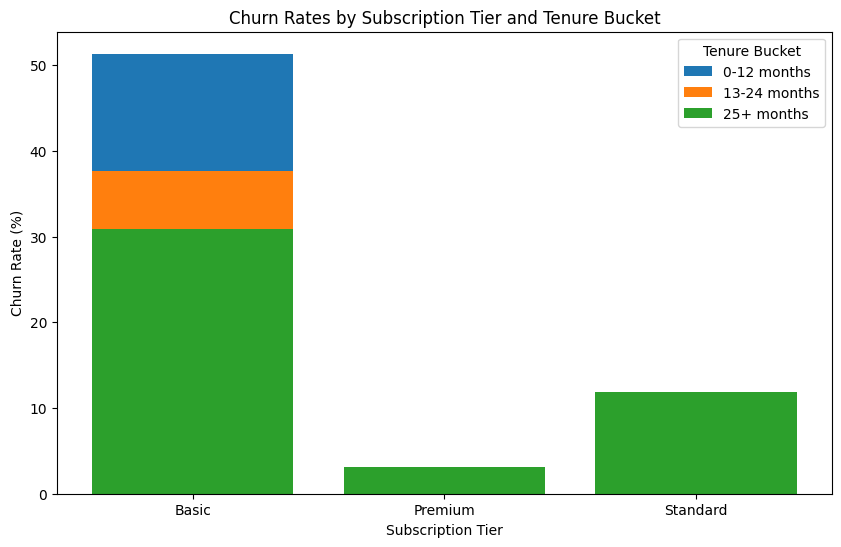

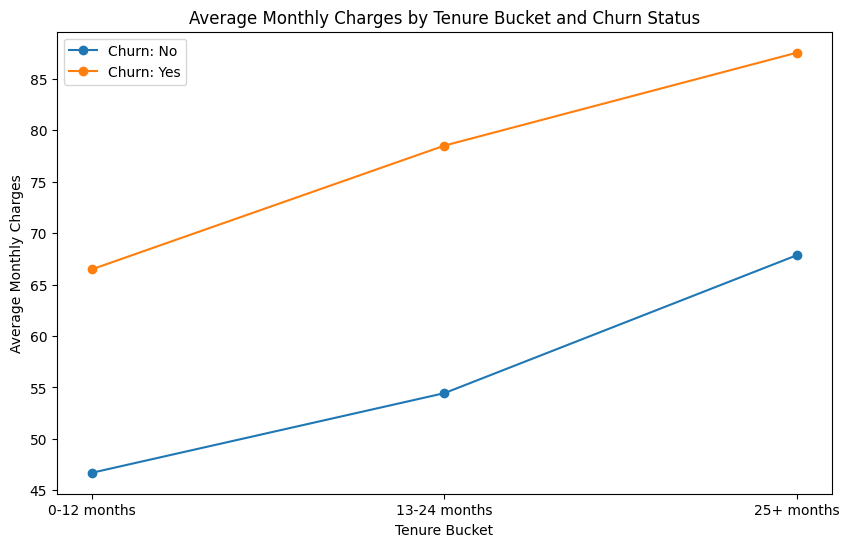

In [7]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, count

# Aggregate churn rates by subscription_tier and tenure_bucket
churn_rates = telecom_df_enriched.groupBy("subscription_tier", "tenure_bucket").agg(
    (avg(when(col("Churn") == "Yes", 1).otherwise(0)) * 100).alias("churn_rate")
).orderBy("subscription_tier", "tenure_bucket")

# Aggregate average MonthlyCharges by tenure_bucket and Churn status
monthly_charges = telecom_df_enriched.groupBy("tenure_bucket", "Churn").agg(
    avg("MonthlyCharges").alias("avg_monthly_charges")
).orderBy("tenure_bucket", "Churn")

# Show aggregated results
print("Churn rates by subscription tier and tenure bucket (%):")
churn_rates.show()

print("Average MonthlyCharges by tenure bucket and Churn status:")
monthly_charges.show()

# Convert to Pandas for visualization
churn_rates_pd = churn_rates.toPandas()
monthly_charges_pd = monthly_charges.toPandas()

# Plot 1: Churn rates by subscription tier
plt.figure(figsize=(10, 6))
for tenure_bucket in churn_rates_pd["tenure_bucket"].unique():
    subset = churn_rates_pd[churn_rates_pd["tenure_bucket"] == tenure_bucket]
    plt.bar(subset["subscription_tier"], subset["churn_rate"], label=tenure_bucket)
plt.title("Churn Rates by Subscription Tier and Tenure Bucket")
plt.xlabel("Subscription Tier")
plt.ylabel("Churn Rate (%)")
plt.legend(title="Tenure Bucket")
plt.show()

# Plot 2: Average MonthlyCharges by tenure bucket and Churn status
plt.figure(figsize=(10, 6))
for churn_status in monthly_charges_pd["Churn"].unique():
    subset = monthly_charges_pd[monthly_charges_pd["Churn"] == churn_status]
    plt.plot(subset["tenure_bucket"], subset["avg_monthly_charges"], marker='o', label=f"Churn: {churn_status}")
plt.title("Average Monthly Charges by Tenure Bucket and Churn Status")
plt.xlabel("Tenure Bucket")
plt.ylabel("Average Monthly Charges")
plt.legend()
plt.show()

## Step 6: Save and Share the Project

In this step, I finalized the *Telco Churn Insights with PySpark* project for submission by saving the notebook and uploading it to GitHub for easy sharing.

- **Saving the Notebook**: I saved the Colab notebook to Google Drive and downloaded it as an `.ipynb` file.
- **Sharing via GitHub**: I created a GitHub repository to host the project, added a README with instructions, and obtained a shareable link.